In [1]:
import sys
sys.path.append('/cluster/sj1/bb_opt/src')
sys.path.append('/cluster/sj1/')

In [2]:
import tensorflow as tf
from tensorflow.keras.backend import set_session

os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

In [3]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn
import numpy as np
import h5py
from collections import namedtuple
import torch.distributions as tdist
from gpu_utils.utils import gpu_init
from tqdm import tnrange
import pandas as pd
from bb_opt.src.utils import train_val_test_split

gpu_id = gpu_init(best_gpu_metric="mem")
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Running on GPU 2


In [5]:
import hsic
import bayesian_opt as bopt
import chemvae_bopt as cbopt
import reparam_trainer as reparam
import utils

Using TensorFlow backend.


In [6]:
from chemvae_keras import vae_utils
from chemvae_keras import mol_utils as mu

In [7]:
chemvae_num_z = 196

In [36]:
Params = namedtuple('params', [
    'train_lr', 
    'output_dist_std', 
    'output_dist_fn',
    'prior_mean', 
    'prior_std', 
    'num_epochs', 
    'num_train_latent_samples', 
    'train_batch_size', 
    'device', 
    'exp_noise_samples',
    'hsic_train_lambda',
    
    'prop_activation',
    'prop_pred_num_input_features',
    'prop_pred_num_random_inputs',
    'prop_pred_num_hidden',
    'prop_pred_dropout',
    'prop_pred_depth',
    'prop_pred_growth_factor',
    'prop_batchnorm',
    
    'ack_batch_size',
    'ack_lr',
    'num_queries',
    'batch_opt_lr',
    'batch_opt_num_iter',
    'input_opt_lr',
    'mves_kernel_fn',
    'input_opt_num_iter',
    'ack_num_model_samples',
    'ack_num_pdts_points',
    'hsic_diversity_lambda',
    
    'retrain_iters',
    
    'score_fn', # order is logp, qed, sas
])

params = Params(
    train_batch_size=50,
    output_dist_std=1,
    output_dist_fn=tdist.Normal,
    num_train_latent_samples=10,
    exp_noise_samples=2,
    train_lr=1e-4, #0.00045619868229310396,
    prior_mean=0.,
    prior_std=1., 
    device='cuda', 
    num_epochs=1000,
    hsic_train_lambda=1.,
    
    prop_activation='relu',
    prop_pred_num_input_features=chemvae_num_z,
    prop_pred_num_random_inputs=10,
    prop_pred_num_hidden=67,
    prop_pred_dropout=0.15694573998898703,
    prop_pred_depth=3,
    prop_pred_growth_factor=0.99028340731314179,
    prop_batchnorm=False,
    
    ack_batch_size=40,
    ack_lr=1e-3,
    num_queries=1,
    batch_opt_lr=1e-3,
    batch_opt_num_iter=2500,
    input_opt_lr=1e-3,
    mves_kernel_fn='mixrq_kernels',
    input_opt_num_iter=2500,
    ack_num_model_samples=1000,
    ack_num_pdts_points=40,
    hsic_diversity_lambda=1000,
    
    retrain_iters=100,
    
    score_fn=lambda x : 5*x[1]-x[2],
)

device = params.device

In [9]:
import bayesian_opt as bopt
import chemvae_bopt as cbopt
import reparam_trainer as reparam

In [10]:
zinc250k, vae, smiles_one_hot, smiles_z, labels = cbopt.load_zinc250k(score_fn=params.score_fn, num_to_load=50000)

read zinc250k from file
Instructions for updating:
keep_dims is deprecated, use keepdims instead


From /cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1208: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
keep_dims is deprecated, use keepdims instead


From /cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1190: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


From /cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1154: calling reduce_max (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Using standarized functions? True
Standarization: estimating mu and std values ...done!
initialized VAEUtils
done 0K samples
done 10K samples
done 20K samples
done 30K samples
done 40K samples
converted to one_hot
processed encoded representation


In [12]:
exclude_top = 0.01
n_train = 1000
selection_methods = ['random', 'sorted', 'random_sorted']
method = 'random_sorted'

num_total = len(zinc250k[0])
idx = np.arange(num_total)

if method == 'random':
    train_idx, _, _ = train_val_test_split(idx, split=[n_train, 0])
    train_idx2, _, test_idx2 = train_val_test_split(n_train, split=[0.9, 0])

    test_idx = train_idx[test_idx2]
    train_idx = train_idx[train_idx2]
elif method == 'sorted':
    num_train = int(0.9 * n_train)
    train_idx = idx[:num_train]
    test_idx = idx[num_train:n_train]
elif method == 'random_sorted':
    train_idx = np.random.choice(np.arange(num_total//2), n_train)
    test_idx = np.random.choice(num_total//2+np.arange(num_total//2), n_train)
    

train_inputs = smiles_z[train_idx]
train_labels = labels[train_idx]
val_inputs = smiles_z[test_idx]
val_labels = labels[test_idx]

In [13]:
train_label_mean = train_labels.mean()
train_label_std = train_labels.std()

train_labels = (train_labels - train_label_mean) / train_label_std
val_labels = (val_labels - train_label_mean) / train_label_std

In [14]:
import chemvae_bopt as cbopt
import reparam_trainer as reparam

In [15]:
model = cbopt.PropertyPredictor(params)
qz = reparam.GaussianQz(params.prop_pred_num_random_inputs)

mu_e = torch.zeros(params.prop_pred_num_random_inputs, requires_grad=False).to(device)
std_e = torch.ones(params.prop_pred_num_random_inputs, requires_grad=False).to(device)

e_dist = tdist.Normal(mu_e + params.prior_mean, std_e*params.prior_std)

In [16]:
train_X = torch.FloatTensor(train_inputs, device='cpu')
train_Y = torch.FloatTensor(train_labels, device='cpu')
val_X = torch.FloatTensor(val_inputs, device='cpu')
val_Y = torch.FloatTensor(val_labels, device='cpu')

In [17]:
train_losses = []
train_kl_losses = []
train_hsic_losses = []
val_losses = []

train_corrs = []
val_corrs = []

In [20]:
data = [train_X, train_Y, val_X, val_Y]
i_losses, i_kl_losses, i_hsic_losses, i_val_losses, i_corrs, i_val_corrs = cbopt.train(params, params.num_train_latent_samples, data, model, qz, e_dist)

train_losses += i_losses
train_kl_losses += i_kl_losses
train_hsic_losses += i_hsic_losses
val_losses += i_val_losses

train_corrs += i_corrs
val_corrs += i_val_corrs

training:
1000 samples
50 batch_size
20 num_batches
1000 num_epochs


A Jupyter Widget

KeyboardInterrupt: 

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


train_corrcoef: 0.9980541972130902
val_corrcoef: 0.09227496130206515


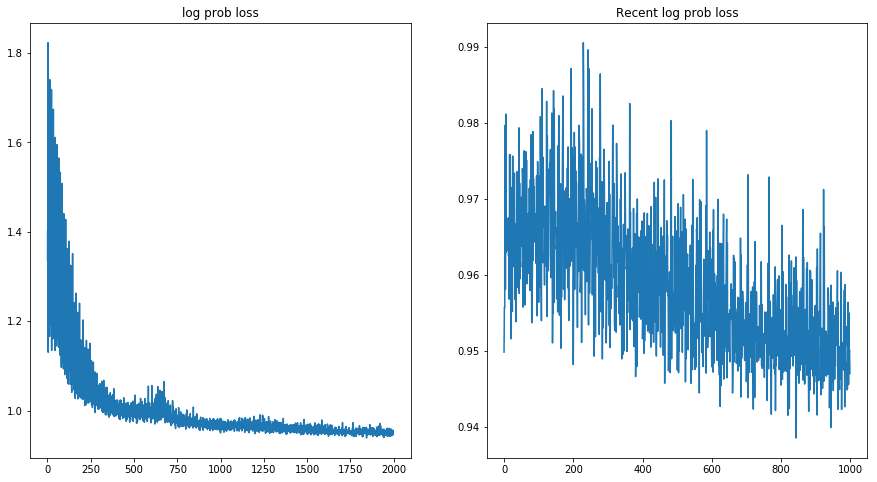

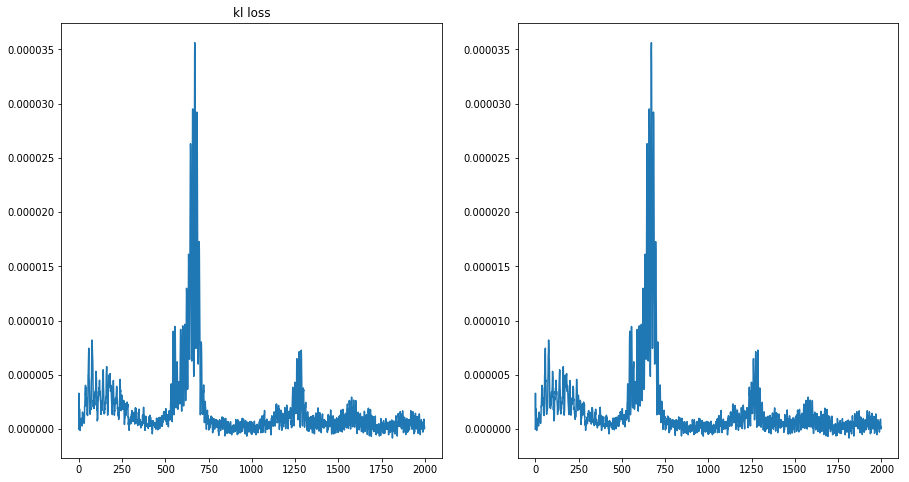

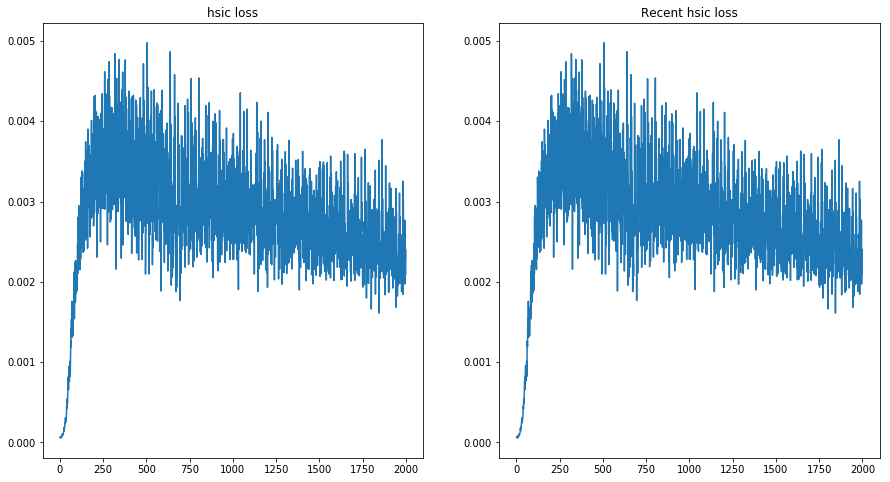

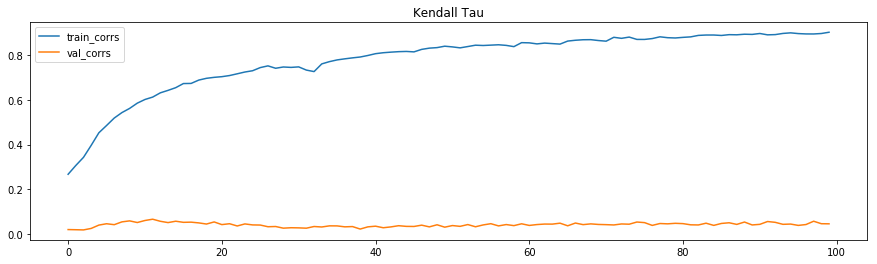

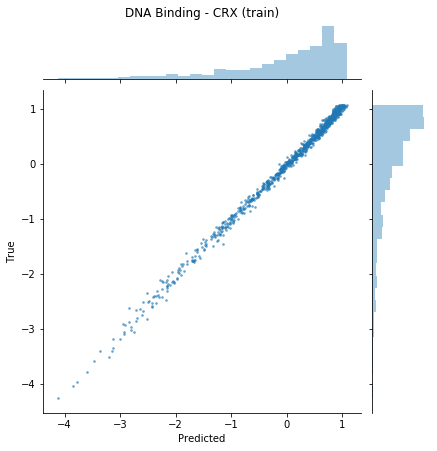

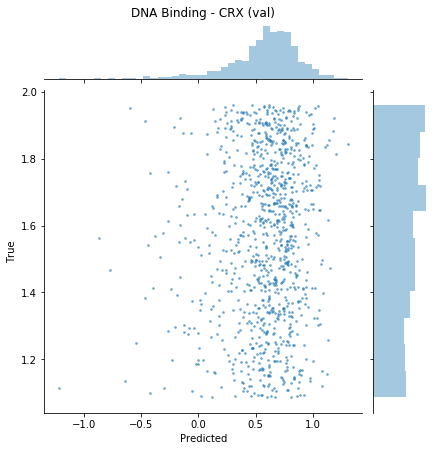

In [21]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.plot(train_losses)
plt.title("log prob loss")

plt.subplot(122)
plt.plot(train_losses[-1000:])
plt.title("Recent log prob loss")

plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.plot(train_kl_losses)
plt.title("kl loss")

plt.subplot(122)
plt.plot(train_kl_losses[-3000:])

plt.figure(figsize=(15, 8))
plt.subplot(121)

plt.plot(train_hsic_losses)
plt.title("hsic loss")

plt.subplot(122)
plt.plot(train_hsic_losses[-3000:])

plt.title("Recent hsic loss")

plt.figure(figsize=(15, 4))

plt.plot(train_corrs, label="train_corrs")
plt.plot(val_corrs, label="val_corrs")
plt.legend()
plt.title("Kendall Tau");

title = "DNA Binding - CRX"
train_title = title + " (train)"
val_title = title + " (val)"

e = reparam.generate_prior_samples(params.num_train_latent_samples, e_dist)
if n_train > 1:
    preds = reparam.predict(train_X, model, qz, e)[:, :, 0].mean(1)
    utils.jointplot(preds, train_labels, train_title)
    print('train_corrcoef:', np.corrcoef(preds, train_labels)[0, 1])

preds = reparam.predict(val_X, model, qz, e)[:, :, 0].mean(1)
utils.jointplot(preds, val_labels, val_title)
print('val_corrcoef:', np.corrcoef(preds, val_labels)[0, 1])

In [115]:
all_pdts = all_pdts[:1]

In [127]:
import bayesian_opt as bopt
import chemvae_bopt as cbopt

In [241]:
temp = np.array(all_pdts[1:])
temp2 = np.array(all_mves[1:])

In [242]:
print(temp.mean(axis=1))
print(temp2.mean(axis=1))
temp3 =temp2.mean(axis=1)-temp.mean(axis=1) 
print(temp3.mean(), temp3.std())

[-0.1339947   0.16060998  0.17266708  0.77405783  0.85855552 -0.18496159
 -0.17320206  0.00263495  1.07008749  0.13317182  0.09011051  0.51049159
 -0.2056348  -0.17598948 -0.44955886]
[-0.10078523  1.08979286  1.33627304  1.05278318  0.05227686  1.16937042
  0.21061194  0.10669252  0.01638572 -0.26792155  0.02673594 -1.10872173
  0.16143727  1.54142351  1.19058402]
0.26852623383204144 0.9496787604920575


In [251]:
e = reparam.generate_prior_samples(params.ack_num_model_samples, e_dist)
model_ensemble = reparam.generate_ensemble_from_stochastic_net(model, e)

In [252]:
input_shape = model.input_shape()

for ack_iter in range(1):
    pdts_points, preds = bopt.optimize_model_input_pdts(params, input_shape, model_ensemble, params.ack_num_model_samples)
    assert preds.shape[1] == 1
    assert preds.ndimension() == 2
    opt_values = preds[:, 0]
    print('done pdts points', preds.shape)

A Jupyter Widget

done pdts points torch.Size([1000, 1])


In [253]:
print(params.ack_num_pdts_points, pdts_points.shape)

40 torch.Size([1000, 196])


In [254]:
for ack_iter in range(1):
    ack_props = []
    points = pdts_points.cpu().numpy()
    pdts_idx = np.random.choice(np.arange(pdts_points.shape[0]), params.ack_num_pdts_points)
    ack_props += [cbopt.acquire_properties(points[pdts_idx], vae, device=params.device)]
    print('decoded pdts_points:', str(ack_props[-1].shape))
    
    ack_labels = []
    for i in range(len(ack_props)):
        new_labels = [params.score_fn(ack_props[i][j]) for j in range(ack_props[i].shape[0])]
        ack_labels += [torch.tensor(new_labels)]
    
    assert len(ack_labels) == 1
    pdts_max_ack = []
    for j in range(100):
        idx = torch.randperm(ack_labels[0].shape[0])
        pdts_max_ack += [torch.max(ack_labels[0][idx[:params.ack_batch_size]]).item()]
    print(np.median(pdts_max_ack))
    all_pdts += [pdts_max_ack]
    
    pdts_labels = ack_labels[0]

decoded pdts_points: torch.Size([221, 3])
-0.3463747501373291


In [255]:
print(pdts_labels.median(), pdts_labels.mean(), pdts_labels.max(), pdts_labels.shape)

tensor(-3.0545) tensor(-3.0144) tensor(0.1518) torch.Size([221])


In [256]:
input_shape = model.input_shape()

for ack_iter in range(params.num_queries):
    """
    ei_batch = bopt.acquire_batch_via_grad_ei(
        params,
        model_ensemble,
        input_shape
    )
    print('done ei')
    """
    
    mves_batch = bopt.acquire_batch_via_grad_mves(params, model_ensemble, input_shape, opt_values, params.ack_batch_size)
    print('done mves')
    
    ack_props = []
    ack_props += [cbopt.acquire_properties(mves_batch.cpu().numpy(), vae, device=params.device)]
    print('decoded mves_points:', str(ack_props[-1].shape))
    
    assert len(ack_labels) == 1
    ack_labels = []
    for i in range(len(ack_props)):
        new_labels = [params.score_fn(ack_props[i][j]) for j in range(ack_props[i].shape[0])]
        ack_labels += [torch.tensor(new_labels)]
        
    mves_max_ack = []
    for j in range(100):
        idx = torch.randperm(ack_labels[0].shape[0])
        mves_max_ack += [torch.max(ack_labels[0][idx[:params.ack_batch_size]]).item()]
    print(np.median(mves_max_ack))
    all_mves += [mves_max_ack]
    
    mves_labels = ack_labels[0]

mves: ack_batch_size 40


A Jupyter Widget

done mves


KeyboardInterrupt: 

In [ ]:
print(mves_labels.median(), mves_labels.mean(), mves_labels.max(), mves_labels.shape)

In [116]:
Params = namedtuple('params', [
    'train_lr', 
    'output_dist_std', 
    'output_dist_fn',
    'prior_mean', 
    'prior_std', 
    'num_epochs', 
    'num_train_latent_samples', 
    'train_batch_size', 
    'device', 
    'exp_noise_samples',
    'hsic_train_lambda',
    
    'prop_activation',
    'prop_pred_num_input_features',
    'prop_pred_num_random_inputs',
    'prop_pred_num_hidden',
    'prop_pred_dropout',
    'prop_pred_depth',
    'prop_pred_growth_factor',
    'prop_batchnorm',
    
    'ack_batch_size',
    'ack_lr',
    'num_queries',
    'batch_opt_lr',
    'batch_opt_num_iter',
    'input_opt_lr',
    'mves_kernel_fn',
    'input_opt_num_iter',
    'ack_num_model_samples',
    'ack_num_pdts_points',
    'hsic_diversity_lambda',
    
    'retrain_iters',
    
    'score_fn', # order is logp, qed, sas
])

params = Params(
    train_batch_size=50,
    output_dist_std=1,
    output_dist_fn=tdist.Normal,
    num_train_latent_samples=10,
    exp_noise_samples=2,
    train_lr=1e-4, #0.00045619868229310396,
    prior_mean=0.,
    prior_std=1., 
    device='cuda', 
    num_epochs=1000,
    hsic_train_lambda=1.,
    
    prop_activation='relu',
    prop_pred_num_input_features=chemvae_num_z,
    prop_pred_num_random_inputs=10,
    prop_pred_num_hidden=67,
    prop_pred_dropout=0.15694573998898703,
    prop_pred_depth=3,
    prop_pred_growth_factor=0.99028340731314179,
    prop_batchnorm=False,
    
    ack_batch_size=40,
    ack_lr=1e-3,
    num_queries=1,
    batch_opt_lr=1e-3,
    batch_opt_num_iter=10000,
    input_opt_lr=1e-3,
    mves_kernel_fn='mixrq_kernels',
    input_opt_num_iter=2500,
    ack_num_model_samples=1000,
    ack_num_pdts_points=40,
    hsic_diversity_lambda=1000,
    
    retrain_iters=100,
    
    score_fn=lambda x : 5*x[1]-x[2],
)

device = params.device